In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.lstm_vae import LSTMVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

2023-12-18 19:34:52,098 - tensorflow - WARNING - From C:\Users\Aless\anaconda3\envs\dslab\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [4]:
LATENT_DIM: int = 5

# Load Data

In [5]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-18 19:34:52,969 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-18 19:35:09,206 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [6]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-18 19:35:09,432 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-18 19:35:09,571 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-18 19:35:09,575 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.14s) ...


(430, 250, 7)


# Modelling

In [25]:
vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [29]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 250, 7)]             0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 256)                  270336    ['input_7[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 5)                    1285      ['lstm_6[0][0]']              
                                                                                                  
 z_log_var (Dense)           (None, 5)                    1285      ['lstm_6[0][0]']              
                                                                                            

In [30]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_12 (Dense)            (None, 16)                96        
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 Decode_1 (Dense)            (None, 250)               16250     
                                                                 
 Decode_2 (Reshape)          (None, 250, 1)            0         
                                                                 
 lstm_7 (LSTM)               (None, 250, 7)            252 

In [31]:
history = vae.fit(tensor, epochs=64, batch_size=4, validation_split=0.2, shuffle=True
                  #,callbacks=[ ReduceLROnPlateau(monitor="val_loss", patience=15), EarlyStopping(monitor="val_loss", patience=20)]
)

Epoch 1/64
86/86 [==============================] - 15s 134ms/step - loss: 743.2135 - reconstruction_loss: 182.4311 - kl_loss: 5.8211 - val_loss: 152.0575 - val_reconstruction_loss: 44.3477 - val_kl_loss: 19.0143
Epoch 2/64
86/86 [==============================] - 10s 114ms/step - loss: 126.6005 - reconstruction_loss: 28.8510 - kl_loss: 3.6478 - val_loss: 50.2921 - val_reconstruction_loss: 14.4729 - val_kl_loss: 6.8734
Epoch 3/64
86/86 [==============================] - 10s 122ms/step - loss: 52.3159 - reconstruction_loss: 15.7701 - kl_loss: 2.5601 - val_loss: 49.2118 - val_reconstruction_loss: 13.5584 - val_kl_loss: 8.5365
Epoch 4/64
86/86 [==============================] - 12s 137ms/step - loss: 47.6293 - reconstruction_loss: 14.6669 - kl_loss: 2.2771 - val_loss: 44.4175 - val_reconstruction_loss: 13.1850 - val_kl_loss: 4.8625
Epoch 5/64
86/86 [==============================] - 12s 143ms/step - loss: 38.9161 - reconstruction_loss: 13.1577 - kl_loss: 1.9039 - val_loss: 45.4815 - val_r

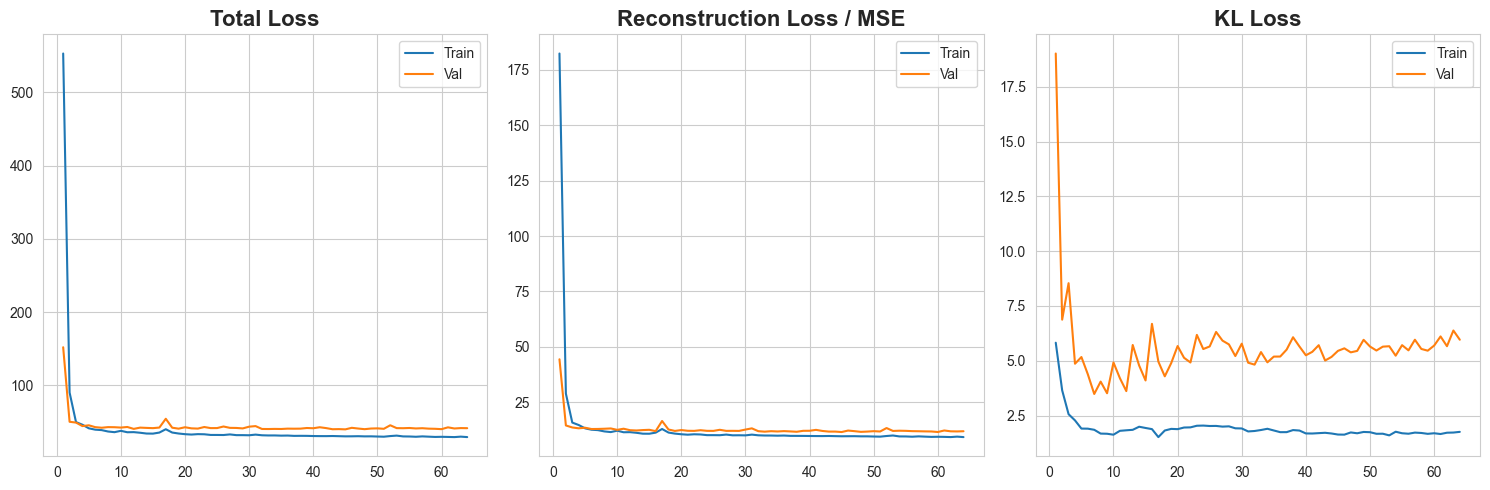

In [32]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [33]:
#vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Reconstruction Plotting

In [34]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [35]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 1s 942ms/step


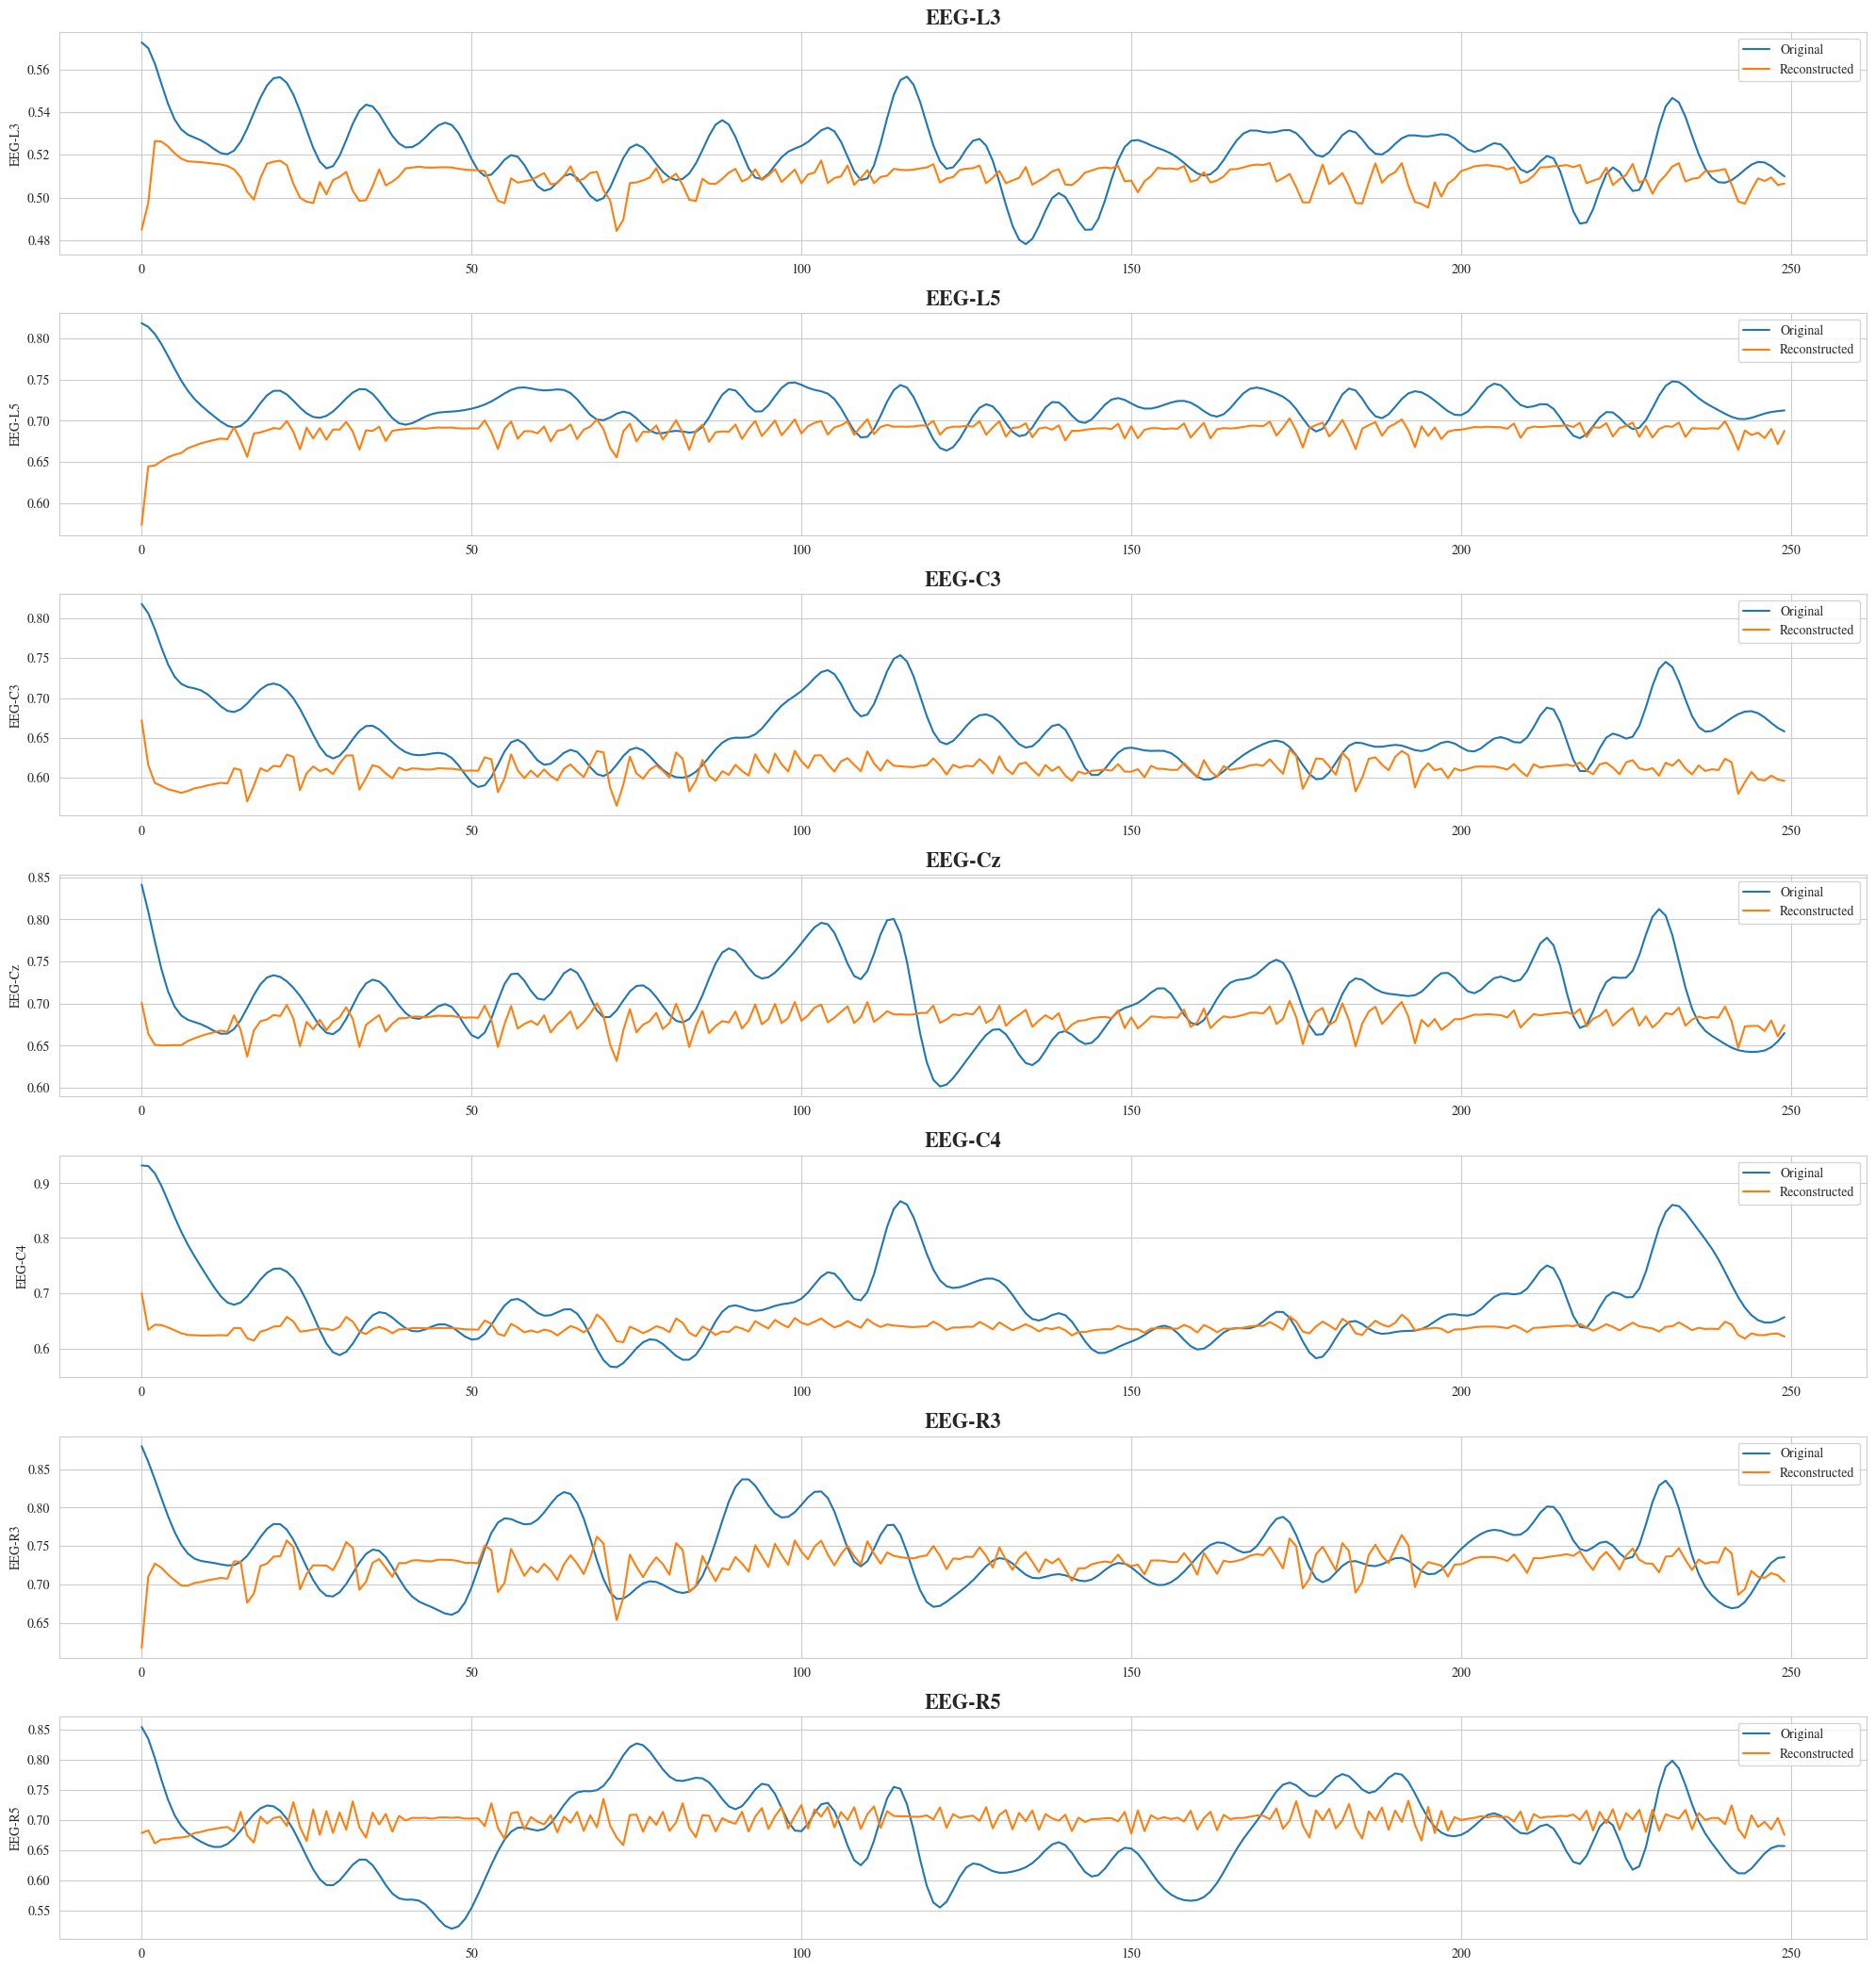

In [115]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [57]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


In [58]:
test_df = pd.DataFrame(synthetic_time_series[0], columns=FEATURE_NAMES)#, index=df_scaled_list[0].index)
test_df

,EEG-L3,EEG-L5,EEG-C3,EEG-Cz,EEG-C4,EEG-R3,EEG-R5
0,0.464074,0.485109,0.563535,0.600126,0.582810,0.524786,0.562083
1,0.472191,0.556684,0.559211,0.597710,0.571775,0.604002,0.626534
2,0.499552,0.561289,0.530291,0.580321,0.580562,0.604273,0.601347
3,0.501760,0.562797,0.521459,0.574129,0.581096,0.591872,0.599750
4,0.503492,0.570621,0.515092,0.571399,0.577895,0.582896,0.597190
...,...,...,...,...,...,...,...
245,0.518940,0.595193,0.503667,0.563939,0.569602,0.583069,0.593731
246,0.519834,0.586306,0.500551,0.557142,0.571197,0.580914,0.590636
247,0.516521,0.601864,0.505677,0.569057,0.566412,0.581507,0.594933
248,0.522244,0.581048,0.501541,0.554955,0.574635,0.585496,0.591654


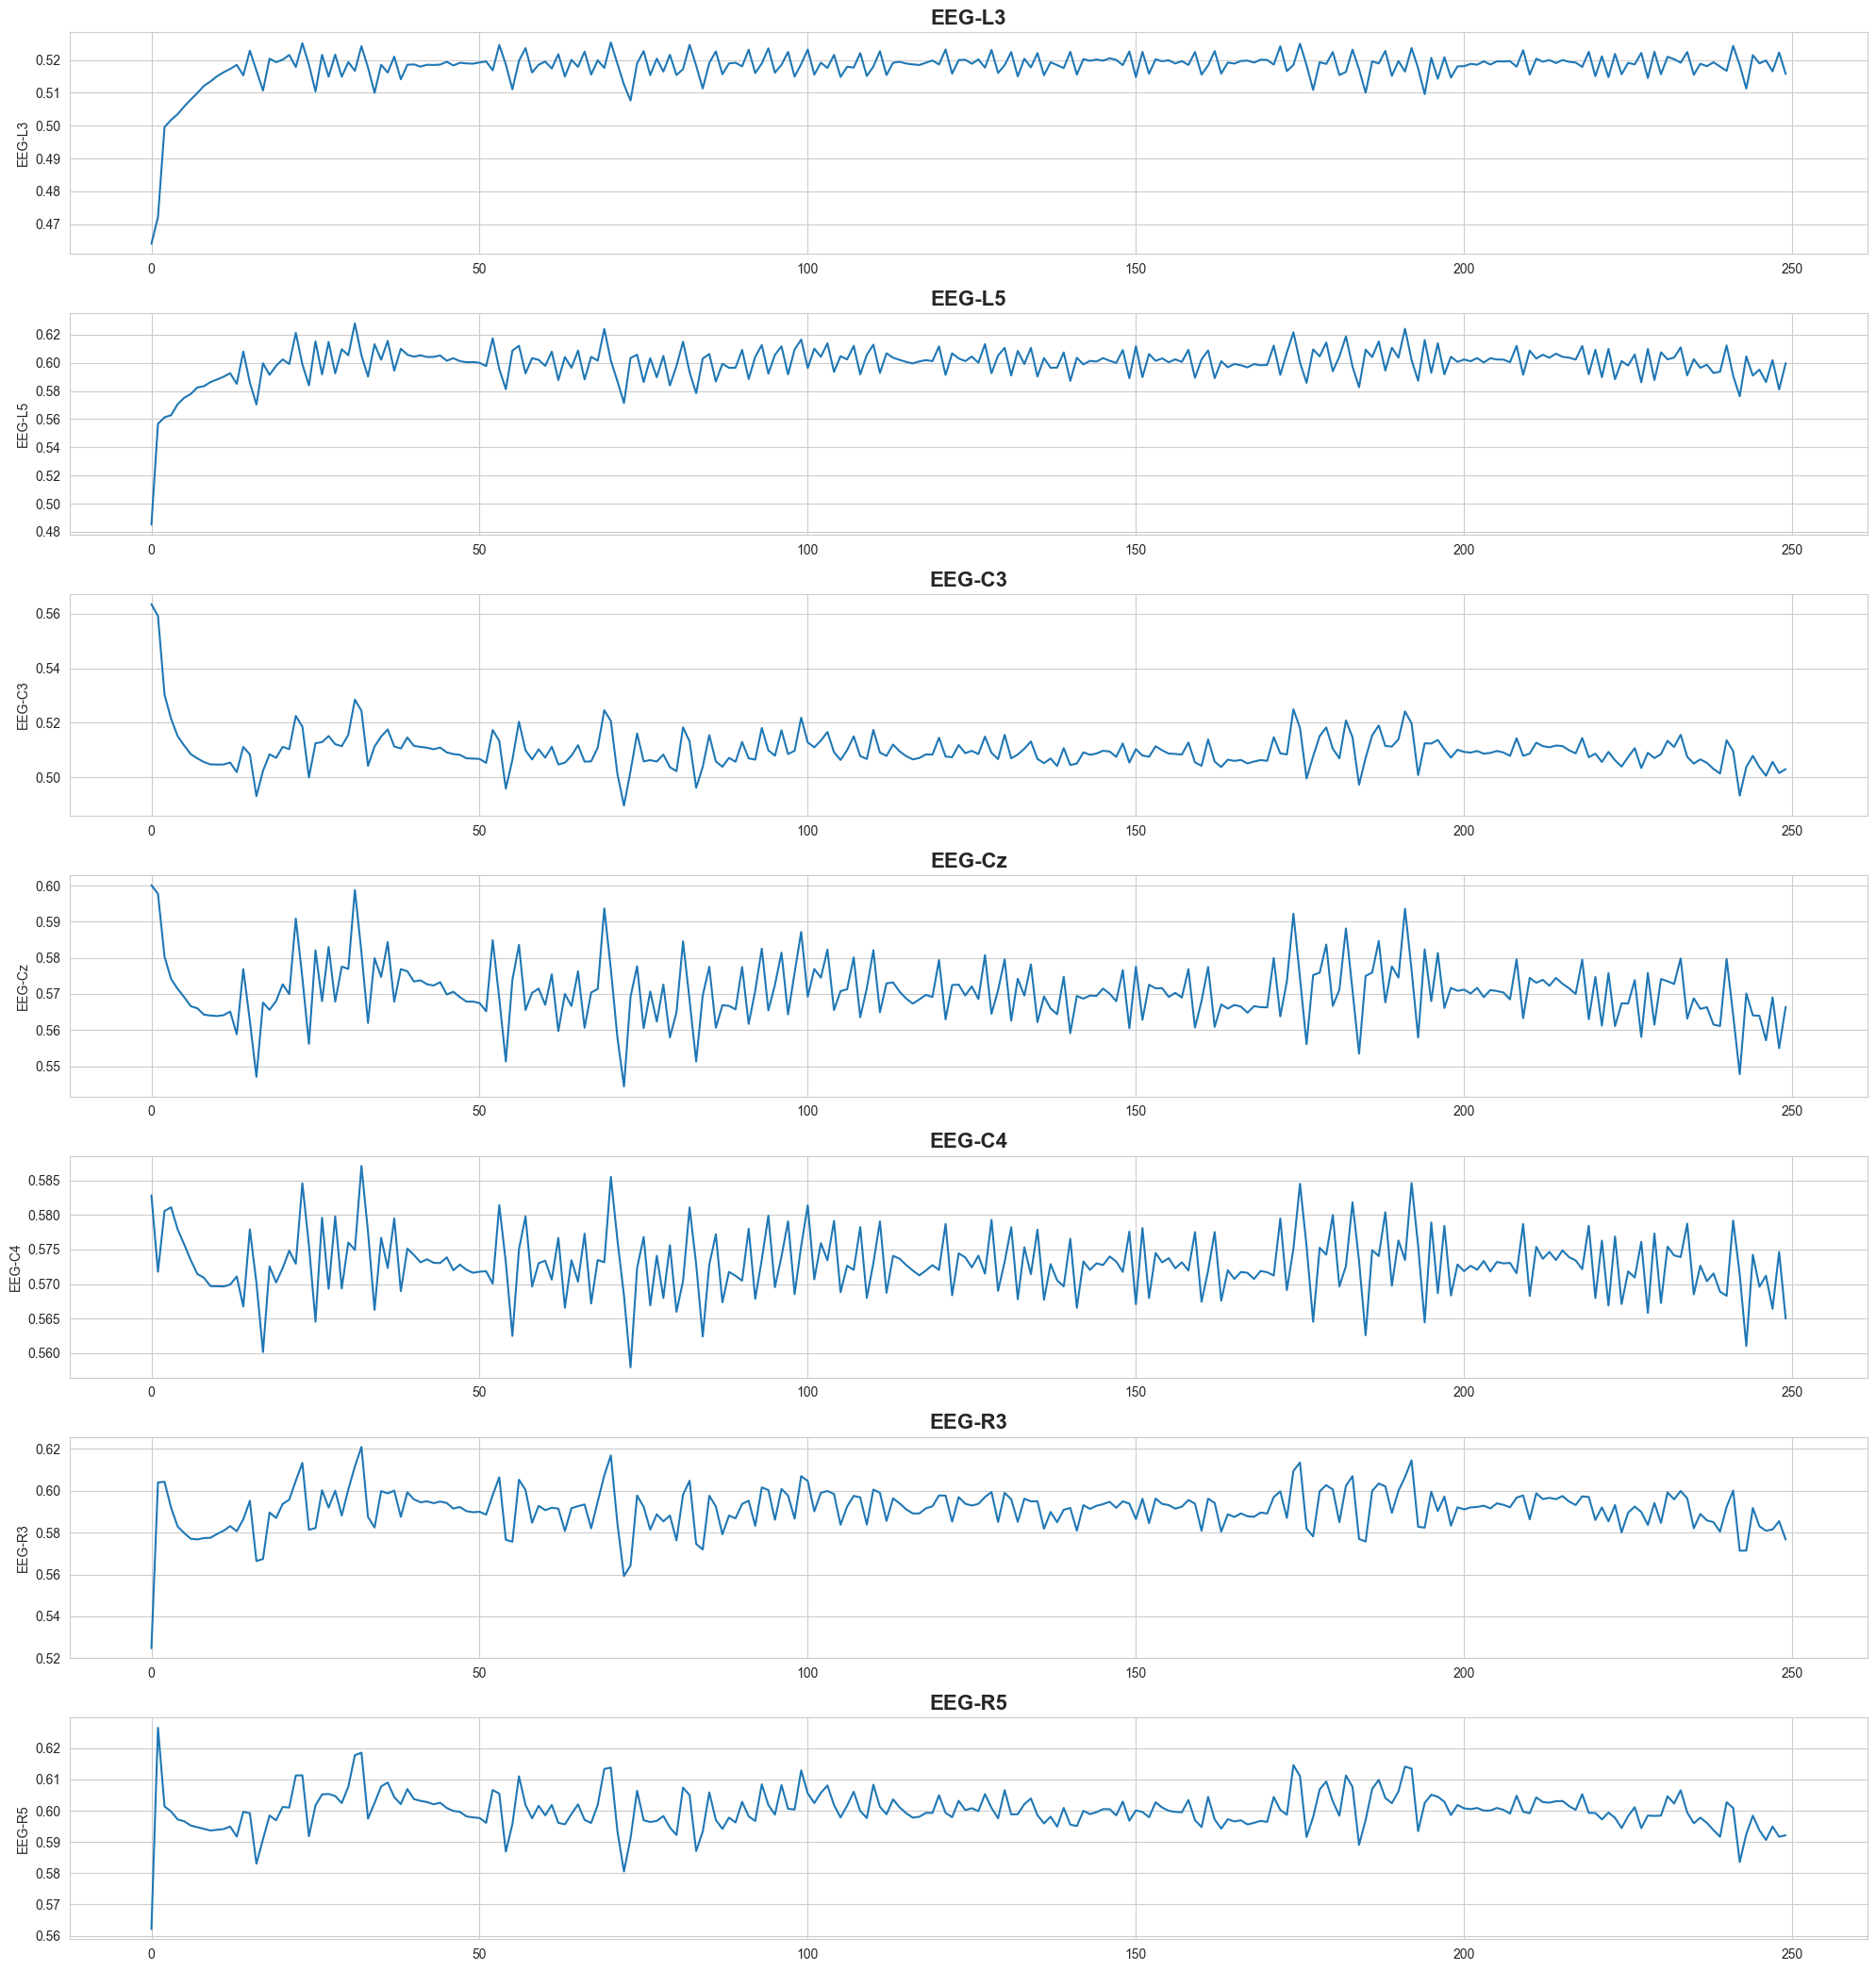

In [59]:
def plot_all_time_series(df: pd.DataFrame) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param df: pd.DataFrame -- Input DataFrame
    :param time_col: str -- Name of the time column
    :return: None
    """
    cols = [x for x in list(df.columns) if x.startswith("EEG")]

    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(20, len(cols)*3))
    for col, ax in zip(cols, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(test_df)

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [97]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)

In [98]:
from sklearn.manifold import TSNE

In [99]:
tsne = TSNE(perplexity=5)
z_dim_reduced = tsne.fit_transform(z)

In [100]:
z_dim_reduced

array([[ 5.02823639e+01,  2.43644772e+01],
       [ 6.50614700e+01,  3.08115673e+01],
       [ 5.38987656e+01,  1.01024637e+01],
       [ 5.08367577e+01,  2.34902840e+01],
       [ 5.41165085e+01,  1.66858444e+01],
       [ 6.49657211e+01,  3.23876648e+01],
       [-4.55290842e+00, -2.65767059e+01],
       [ 4.09252205e+01,  2.29733448e+01],
       [ 5.92752800e+01,  1.91206093e+01],
       [ 4.94136543e+01,  2.50612011e+01],
       [ 5.12858276e+01,  3.05039806e+01],
       [ 5.67492638e+01,  1.79192219e+01],
       [ 5.40038948e+01,  1.08738356e+01],
       [ 5.36014481e+01,  3.04721889e+01],
       [ 6.41254425e+01,  3.05669937e+01],
       [ 4.97168846e+01,  2.63313808e+01],
       [ 3.05755005e+01,  2.22895107e+01],
       [ 2.36589851e+01,  4.46303787e+01],
       [ 4.93057785e+01,  4.23191977e+00],
       [ 4.91869850e+01,  3.16513596e+01],
       [ 5.58430595e+01,  1.44653206e+01],
       [ 4.66754990e+01,  3.26015968e+01],
       [ 3.81542397e+01,  3.17429314e+01],
       [-2.

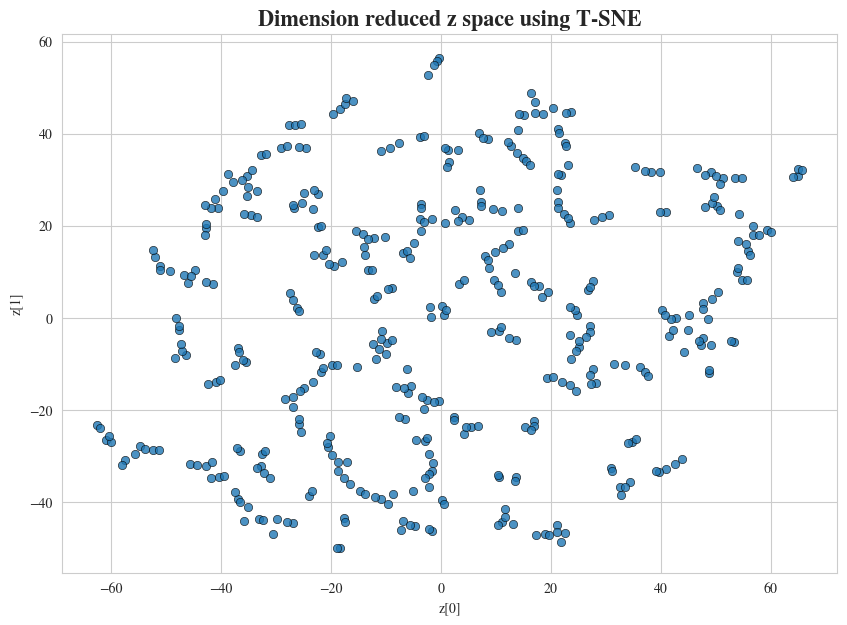

In [113]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8)
ax.set_xlabel("z[0]")
ax.set_ylabel("z[1]")
fig.show()